## Games Recommended system


#### Import necessary libraries

In [13]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


In [14]:
# Download necessary NLTK datasets
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load Datasets

In [15]:
games_df=pd.read_csv(r"/content/games_metadata_5k.xls")
ratings_df=pd.read_csv(r"/content/game_ratings.csv")

In [16]:
print(games_df.shape)
print(ratings_df.shape)

(5000, 10)
(273669, 3)


In [17]:
games_df.head() #displays first 5 rows of the dataset.

,game_id,name,description,genres,platforms,rating,released,cover_image,game_link,metacritic_url
0,3498,Grand Theft Auto V,"<p>Rockstar Games went bigger, since their pre...",Action,"PC, PlayStation 5, Xbox Series S/X, PlayStatio...",4.47,2013-09-17,https://media.rawg.io/media/games/20a/20aa03a1...,https://rawg.io/games/grand-theft-auto-v,"<p>Rockstar Games went bigger, since their pre..."
1,3328,The Witcher 3: Wild Hunt,"<p>The third game in a series, it holds nothin...","Action, RPG","Xbox Series S/X, PlayStation 5, macOS, PlaySta...",4.65,2015-05-18,https://media.rawg.io/media/games/618/618c2031...,https://rawg.io/games/the-witcher-3-wild-hunt,"<p>The third game in a series, it holds nothin..."
2,4200,Portal 2,<p>Portal 2 is a first-person puzzle game deve...,"Shooter, Puzzle","PlayStation 3, PC, Xbox 360, Linux, macOS, Xbo...",4.59,2011-04-18,https://media.rawg.io/media/games/2ba/2bac0e87...,https://rawg.io/games/portal-2,<p>Portal 2 is a first-person puzzle game deve...
3,4291,Counter-Strike: Global Offensive,<p>Counter-Strike is a multiplayer phenomenon ...,Shooter,"PC, Linux, Xbox 360, PlayStation 3",3.56,2012-08-21,https://media.rawg.io/media/games/736/73619bd3...,https://rawg.io/games/counter-strike-global-of...,<p>Counter-Strike is a multiplayer phenomenon ...
4,5286,Tomb Raider (2013),<p>A cinematic revival of the series in its ac...,Action,"PlayStation 3, Xbox 360, macOS, PC, Xbox One, ...",4.06,2013-03-05,https://media.rawg.io/media/games/021/021c4e21...,https://rawg.io/games/tomb-raider,<p>A cinematic revival of the series in its ac...


In [18]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   game_id         5000 non-null   int64  
 1   name            5000 non-null   object 
 2   description     4970 non-null   object 
 3   genres          4976 non-null   object 
 4   platforms       4999 non-null   object 
 5   rating          5000 non-null   float64
 6   released        4964 non-null   object 
 7   cover_image     4996 non-null   object 
 8   game_link       5000 non-null   object 
 9   metacritic_url  4970 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 390.8+ KB


We don't need the `metacritic_url` column, so let's drop it.

In [19]:
games_df.drop("metacritic_url",axis=1,inplace=True)
games_df.shape

(5000, 9)

In [20]:
missing_values=pd.DataFrame({"null_values":games_df.isnull().sum(),"% of missing_values":(games_df.isnull().sum()/len(games_df)*100)})
print(missing_values.sort_values(by="% of missing_values",ascending=False))

             null_values  % of missing_values
released              36                 0.72
description           30                 0.60
genres                24                 0.48
cover_image            4                 0.08
platforms              1                 0.02
game_id                0                 0.00
name                   0                 0.00
rating                 0                 0.00
game_link              0                 0.00


In [21]:
games_df["description"] = games_df.apply(
    lambda row: f"The game '{row['name']}' is a {row['genres']} game available on {row['platforms']}, released in {row['released']}. Explore an exciting and immersive experience!" if pd.isna(row['description']) else row['description'],
    axis=1
)
# Fill missing values for genres and platforms with "Unknown"
games_df["genres"].fillna("Unknown", inplace=True)
games_df["platforms"].fillna("Unknown", inplace=True)
games_df["cover_image"].fillna("Unknown", inplace=True)
# Check for missing values again
print(games_df.isnull().sum())

game_id         0
name            0
description     0
genres          0
platforms       0
rating          0
released       36
cover_image     0
game_link       0
dtype: int64


As we do not use released column for our recommendation system, we can drop it.

In [22]:
games_df.drop("released",axis=1,inplace=True)
games_df.shape

(5000, 8)

### Content Based Filtering

One popular technique of recommendation systems is content-based filtering. Content here refers to the content or attributes of the products you like. So, the idea in content-based filtering is to tag products using certain keywords, understand what the user likes, look up those keywords in the database and recommend different products with the same attributes.

### Preprocessing

For content-based filtering, we don't need the rating, cover image, and game link columns. So, let's filter out these columns by selecting the relevant ones

In [23]:
cbf_df=games_df[["game_id","name","description","genres","platforms"]]
cbf_df.head()

,game_id,name,description,genres,platforms
0,3498,Grand Theft Auto V,"<p>Rockstar Games went bigger, since their pre...",Action,"PC, PlayStation 5, Xbox Series S/X, PlayStatio..."
1,3328,The Witcher 3: Wild Hunt,"<p>The third game in a series, it holds nothin...","Action, RPG","Xbox Series S/X, PlayStation 5, macOS, PlaySta..."
2,4200,Portal 2,<p>Portal 2 is a first-person puzzle game deve...,"Shooter, Puzzle","PlayStation 3, PC, Xbox 360, Linux, macOS, Xbo..."
3,4291,Counter-Strike: Global Offensive,<p>Counter-Strike is a multiplayer phenomenon ...,Shooter,"PC, Linux, Xbox 360, PlayStation 3"
4,5286,Tomb Raider (2013),<p>A cinematic revival of the series in its ac...,Action,"PlayStation 3, Xbox 360, macOS, PC, Xbox One, ..."


Now, let's combine the columns 'name', 'genres', 'platforms', and 'description' into a corpus and perform vectorization.

Before that we need to perform some preprocessing.

In [24]:
cbf_df["description"].head()

,description
0,"<p>Rockstar Games went bigger, since their pre..."
1,"<p>The third game in a series, it holds nothin..."
2,<p>Portal 2 is a first-person puzzle game deve...
3,<p>Counter-Strike is a multiplayer phenomenon ...
4,<p>A cinematic revival of the series in its ac...


In [25]:
def clean(text):

    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags like <br>, <p>, etc.
    text = re.sub(r'<[^>]+>', ' ', text)

    # Remove newlines
    text = re.sub(r"\n", " ", text)

    # Remove URLs and emails
    text = re.sub(r'\b(?:https?|ftp):\/\/[^\s]+', ' ', text)  # Removes URLs
    text = re.sub(r'\b\w+@\w+\.\w+', " ", text)  # Removes email addresses

    # Remove numbers
    text = re.sub(r'\d+', " ", text)

    # Remove non-alphanumeric characters (punctuation) except spaces
    text = re.sub(f'[{string.punctuation}]', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', " ", text).strip()

    return text



In [26]:
cbf_df["description"]=cbf_df["description"].apply(clean)
cbf_df["description"].head()

,description
0,rockstar games went bigger since their previou...
1,the third game in a series it holds nothing ba...
2,portal is a first person puzzle game developed...
3,counter strike is a multiplayer phenomenon in ...
4,a cinematic revival of the series in its actio...


In [27]:
cbf_df["description"]=cbf_df["description"].apply(lambda x: x.split())
cbf_df["description"].head()

,description
0,"[rockstar, games, went, bigger, since, their, ..."
1,"[the, third, game, in, a, series, it, holds, n..."
2,"[portal, is, a, first, person, puzzle, game, d..."
3,"[counter, strike, is, a, multiplayer, phenomen..."
4,"[a, cinematic, revival, of, the, series, in, i..."


In [28]:
cbf_df["genres"]=cbf_df["genres"].apply(lambda x: x.split(","))
cbf_df["platforms"]=cbf_df["platforms"].apply(lambda x: x.split(","))

In [29]:
print(cbf_df["genres"])


0                                 [Action]
1                           [Action,  RPG]
2                       [Shooter,  Puzzle]
3                                [Shooter]
4                                 [Action]
                       ...                
4995                           [Adventure]
4996    [Action,  Arcade,  Casual,  Indie]
4997                     [Adventure,  RPG]
4998                              [Action]
4999                      [Casual,  Indie]
Name: genres, Length: 5000, dtype: object


In [30]:
pd.set_option('display.max_colwidth', None)
print(cbf_df["platforms"])

0       [PC,  PlayStation 5,  Xbox Series S/X,  PlayStation 4,  PlayStation 3,  Xbox 360,  Xbox One]
1        [Xbox Series S/X,  PlayStation 5,  macOS,  PlayStation 4,  Nintendo Switch,  PC,  Xbox One]
2                                         [PlayStation 3,  PC,  Xbox 360,  Linux,  macOS,  Xbox One]
3                                                            [PC,  Linux,  Xbox 360,  PlayStation 3]
4                                 [PlayStation 3,  Xbox 360,  macOS,  PC,  Xbox One,  PlayStation 4]
                                                    ...                                             
4995                                                                                            [PC]
4996                                                            [Linux,  PC,  Android,  iOS,  macOS]
4997                                                                                   [Nintendo DS]
4998                                                                               [Nintend

In [31]:
cbf_df["name"].head()

,name
0,Grand Theft Auto V
1,The Witcher 3: Wild Hunt
2,Portal 2
3,Counter-Strike: Global Offensive
4,Tomb Raider (2013)


Let's remove spaces within `name`, `platform` and `genre` names to make them more consistent.

In [32]:
cbf_df["genres"]=cbf_df["genres"].apply(lambda x:[i.replace(" ","") for i in x])
cbf_df["platforms"]=cbf_df["platforms"].apply(lambda x:[i.replace(" ","") for i in x])

In [33]:
print(cbf_df["genres"])

0                              [Action]
1                         [Action, RPG]
2                     [Shooter, Puzzle]
3                             [Shooter]
4                              [Action]
                     ...               
4995                        [Adventure]
4996    [Action, Arcade, Casual, Indie]
4997                   [Adventure, RPG]
4998                           [Action]
4999                    [Casual, Indie]
Name: genres, Length: 5000, dtype: object


In [34]:
pd.set_option('display.max_colwidth', None)
print(cbf_df["platforms"])

0       [PC, PlayStation5, XboxSeriesS/X, PlayStation4, PlayStation3, Xbox360, XboxOne]
1       [XboxSeriesS/X, PlayStation5, macOS, PlayStation4, NintendoSwitch, PC, XboxOne]
2                                    [PlayStation3, PC, Xbox360, Linux, macOS, XboxOne]
3                                                    [PC, Linux, Xbox360, PlayStation3]
4                             [PlayStation3, Xbox360, macOS, PC, XboxOne, PlayStation4]
                                             ...                                       
4995                                                                               [PC]
4996                                                   [Linux, PC, Android, iOS, macOS]
4997                                                                       [NintendoDS]
4998                                                                   [NintendoSwitch]
4999                                                                 [PC, Linux, macOS]
Name: platforms, Length: 5000, d

In [35]:
cbf_df["corpus"]=cbf_df["genres"]+cbf_df["platforms"]+cbf_df["description"]
new_df=cbf_df[["game_id","name","corpus"]]
new_df.head()

,game_id,name,corpus
0,3498,Grand Theft Auto V,"[Action, PC, PlayStation5, XboxSeriesS/X, PlayStation4, PlayStation3, Xbox360, XboxOne, rockstar, games, went, bigger, since, their, previous, installment, of, the, series, you, get, the, complicated, and, realistic, world, building, from, liberty, city, of, gta, in, the, setting, of, lively, and, diverse, los, santos, from, an, old, fan, favorite, gta, san, andreas, different, vehicles, including, every, transport, you, can, operate, and, the, amount, is, rising, with, every, update, simultaneous, storytelling, from, three, unique, perspectives, follow, michael, ex, criminal, living, his, life, of, leisure, away, from, the, past, franklin, a, kid, that, seeks, the, better, future, and, trevor, the, exact, past, michael, is, trying, ...]"
1,3328,The Witcher 3: Wild Hunt,"[Action, RPG, XboxSeriesS/X, PlayStation5, macOS, PlayStation4, NintendoSwitch, PC, XboxOne, the, third, game, in, a, series, it, holds, nothing, back, from, the, player, open, world, adventures, of, the, renowned, monster, slayer, geralt, of, rivia, are, now, even, on, a, larger, scale, following, the, source, material, more, accurately, this, time, geralt, is, trying, to, find, the, child, of, the, prophecy, ciri, while, making, a, quick, coin, from, various, contracts, on, the, side, great, attention, to, the, world, building, above, all, creates, an, immersive, story, where, your, decisions, will, shape, the, world, around, you, cd, project, red, are, infamous, for, the, amount, of, ...]"
2,4200,Portal 2,"[Shooter, Puzzle, PlayStation3, PC, Xbox360, Linux, macOS, XboxOne, portal, is, a, first, person, puzzle, game, developed, by, valve, corporation, and, released, on, april, on, steam, ps, and, xbox, it, was, published, by, valve, corporation, in, digital, form, and, by, electronic, arts, in, physical, form, its, plot, directly, follows, the, first, game, s, taking, place, in, the, half, life, universe, you, play, as, chell, a, test, subject, in, a, research, facility, formerly, ran, by, the, company, aperture, science, but, taken, over, by, an, evil, ai, that, turned, upon, its, creators, glados, after, defeating, glados, at, the, end, of, the, first, game, ...]"
3,4291,Counter-Strike: Global Offensive,"[Shooter, PC, Linux, Xbox360, PlayStation3, counter, strike, is, a, multiplayer, phenomenon, in, its, simplicity, no, complicated, narratives, to, explain, the, source, of, the, conflict, no, futuristic, and, alien, threats, but, counter, terrorists, against, terrorists, arena, shooter, at, its, core, cs, go, provides, you, with, various, methods, of, disposing, enemies, and, reliant, on, cooperation, within, the, team, during, the, round, of, the, classical, clash, mode, you, will, gradually, receive, currency, to, purchase, different, equipment, each, player, can, carry, a, primary, weapon, secondary, pistol, knife, and, a, set, of, grenades, which, all, can, change, the, battle, if, wielded, by, the, skilled, player, ...]"
4,5286,Tomb Raider (2013),"[Action, PlayStation3, Xbox360, macOS, PC, XboxOne, PlayStation4, a, cinematic, revival, of, the, series, in, its, action, third, person, form, tomb, rider, follows, lara, in, her, least, experience, period, of, life, –, her, youth, heavily, influenced, by, naughty, dog’s, “uncharted”, the, game, is, a, mix, of, everything, from, stealth, and, survival, to, combat, and, qte, action, scenes, young, lara, croft, arrives, on, the, yamatai, lost, island, near, japan, as, the, leader, of, the, expedition, in, search, of, the, yamatai, kingdom, with, a, diverse, team, of, specialists, but, shipwreck, postponed, the, successful, arrival, and, seemingly, forgotten, island, is, heavily, populated, with, hostile, ...]"


convert corpus into single string.

In [36]:
new_df["corpus"]=cbf_df["corpus"].apply(lambda x:" ".join(x))

In [37]:
new_df.head()

,game_id,name,corpus
0,3498,Grand Theft Auto V,Action PC PlayStation5 XboxSeriesS/X PlayStation4 PlayStation3 Xbox360 XboxOne rockstar games went bigger since their previous installment of the series you get the complicated and realistic world building from liberty city of gta in the setting of lively and diverse los santos from an old fan favorite gta san andreas different vehicles including every transport you can operate and the amount is rising with every update simultaneous storytelling from three unique perspectives follow michael ex criminal living his life of leisure away from the past franklin a kid that seeks the better future and trevor the exact past michael is trying to run away from gta online will provide a lot of additional challenge even for the experienced players coming fresh from the story mode now you will have other players around that can help you just as likely as ruin your mission every gta mechanic up to date can be experienced by players through the unique customizable character and community content paired with the leveling system tends to keep everyone busy and engaged español rockstar games se hizo más grande desde su entrega anterior de la serie obtienes la construcción del mundo complicada y realista de liberty city de gta en el escenario de los santos un viejo favorito de los fans gta san andreas vehículos diferentes incluidos todos los transportes que puede operar y la cantidad aumenta con cada actualización narración simultánea desde tres perspectivas únicas sigue a michael ex criminal que vive su vida de ocio lejos del pasado franklin un niño que busca un futuro mejor y trevor el pasado exacto del que michael está tratando de huir gta online proporcionará muchos desafíos adicionales incluso para los jugadores experimentados recién llegados del modo historia ahora tendrás otros jugadores cerca que pueden ayudarte con la misma probabilidad que arruinar tu misión los jugadores pueden experimentar todas las mecánicas de gta actualizadas a través del personaje personalizable único y el contenido de la comunidad combinado con el sistema de nivelación tiende a mantener a todos ocupados y comprometidos
1,3328,The Witcher 3: Wild Hunt,Action RPG XboxSeriesS/X PlayStation5 macOS PlayStation4 NintendoSwitch PC XboxOne the third game in a series it holds nothing back from the player open world adventures of the renowned monster slayer geralt of rivia are now even on a larger scale following the source material more accurately this time geralt is trying to find the child of the prophecy ciri while making a quick coin from various contracts on the side great attention to the world building above all creates an immersive story where your decisions will shape the world around you cd project red are infamous for the amount of work they put into their games and it shows because aside from classic third person action rpg base game they provided massive dlcs with unique questlines and smaller dlcs containing extra quests and items players praise the game for its atmosphere and a wide open world that finds the balance between fantasy elements and realistic and believable mechanics and the game deserved numerous awards for every aspect of the game from music to direction
2,4200,Portal 2,Shooter Puzzle PlayStation3 PC Xbox360 Linux macOS XboxOne portal is a first person puzzle game developed by valve corporation and released on april on steam ps and xbox it was published by valve corporation in digital form and by electronic arts in physical form its plot directly follows the first game s taking place in the half life universe you play as chell a test subject in a research facility formerly ran by the company aperture science but taken over by an evil ai that turned upon its creators glados after defeating glados at the end of the first game but failing to escape the facility chell is woken up from a stasis chamber by an ai personality core wheatley as the unkempt complex is falling apart as the two attempt to nav

In [38]:
new_df["corpus"]=new_df["corpus"].apply(clean)

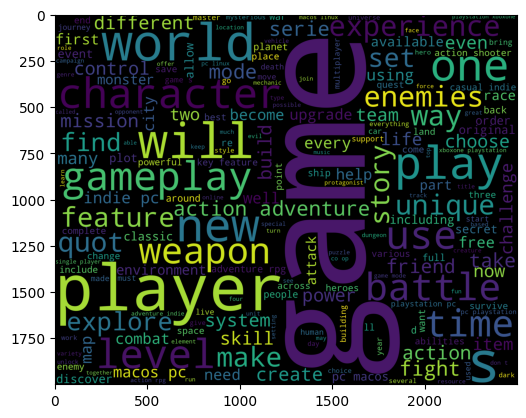

In [39]:
from wordcloud import WordCloud

wordcloud_stw = WordCloud( background_color= 'black',
                width = 2500,
                height = 2000).generate(" ".join(new_df["corpus"]))
plt.imshow(wordcloud_stw)

### Lemmatization

Lets apply lemmatization to the data. Which reduces the words to their base form.

In [40]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

In [41]:
# Define function for Lemmatization
def lemmatize_text(text):
    # Tokenize the text
    words = word_tokenize(text)

    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]


    return lemmatized_words

In [42]:
new_df["corpus"] = new_df["corpus"].apply(lemmatize_text)
new_df["corpus"].head()

,corpus
0,"[action, pc, playstation, xboxseriess, x, playstation, playstation, xbox, xboxone, rockstar, game, went, bigger, since, their, previous, installment, of, the, series, you, get, the, complicated, and, realistic, world, building, from, liberty, city, of, gta, in, the, setting, of, lively, and, diverse, los, santos, from, an, old, fan, favorite, gta, san, andreas, different, vehicle, including, every, transport, you, can, operate, and, the, amount, is, rising, with, every, update, simultaneous, storytelling, from, three, unique, perspective, follow, michael, ex, criminal, living, his, life, of, leisure, away, from, the, past, franklin, a, kid, that, seek, the, better, future, and, trevor, the, exact, past, michael, is, ...]"
1,"[action, rpg, xboxseriess, x, playstation, macos, playstation, nintendoswitch, pc, xboxone, the, third, game, in, a, series, it, hold, nothing, back, from, the, player, open, world, adventure, of, the, renowned, monster, slayer, geralt, of, rivia, are, now, even, on, a, larger, scale, following, the, source, material, more, accurately, this, time, geralt, is, trying, to, find, the, child, of, the, prophecy, ciri, while, making, a, quick, coin, from, various, contract, on, the, side, great, attention, to, the, world, building, above, all, creates, an, immersive, story, where, your, decision, will, shape, the, world, around, you, cd, project, red, are, infamous, for, the, amount, ...]"
2,"[shooter, puzzle, playstation, pc, xbox, linux, macos, xboxone, portal, is, a, first, person, puzzle, game, developed, by, valve, corporation, and, released, on, april, on, steam, p, and, xbox, it, wa, published, by, valve, corporation, in, digital, form, and, by, electronic, art, in, physical, form, it, plot, directly, follows, the, first, game, s, taking, place, in, the, half, life, universe, you, play, a, chell, a, test, subject, in, a, research, facility, formerly, ran, by, the, company, aperture, science, but, taken, over, by, an, evil, ai, that, turned, upon, it, creator, glados, after, defeating, glados, at, the, end, of, the, first, game, ...]"
3,"[shooter, pc, linux, xbox, playstation, counter, strike, is, a, multiplayer, phenomenon, in, it, simplicity, no, complicated, narrative, to, explain, the, source, of, the, conflict, no, futuristic, and, alien, threat, but, counter, terrorist, against, terrorist, arena, shooter, at, it, core, c, go, provides, you, with, various, method, of, disposing, enemy, and, reliant, on, cooperation, within, the, team, during, the, round, of, the, classical, clash, mode, you, will, gradually, receive, currency, to, purchase, different, equipment, each, player, can, carry, a, primary, weapon, secondary, pistol, knife, and, a, set, of, grenade, which, all, can, change, the, battle, if, wielded, by, the, skilled, player, ...]"
4,"[action, playstation, xbox, macos, pc, xboxone, playstation, a, cinematic, revival, of, the, series, in, it, action, third, person, form, tomb, rider, follows, lara, in, her, least, experience, period, of, life, –, her, youth, heavily, influenced, by, naughty, dog, ’, s, “, uncharted, ”, the, game, is, a, mix, of, everything, from, stealth, and, survival, to, combat, and, qte, action, scene, young, lara, croft, arrives, on, the, yamatai, lost, island, near, japan, a, the, leader, of, the, expedition, in, search, of, the, yamatai, kingdom, with, a, diverse, team, of, specialist, but, shipwreck, postponed, the, successful, arrival, and, seemingly, forgotten, island, is, ...]"


In [43]:
new_df["corpus"]=cbf_df["corpus"].apply(lambda x:" ".join(x))

Let's add a few columns to the new_df from games_df, which may be used later.


In [44]:
new_df = pd.concat([new_df, games_df[["rating", "cover_image", "game_link", "genres", "platforms"]]], axis=1)
new_df.head(2)

,game_id,name,corpus,rating,cover_image,game_link,genres,platforms
0,3498,Grand Theft Auto V,Action PC PlayStation5 XboxSeriesS/X PlayStation4 PlayStation3 Xbox360 XboxOne rockstar games went bigger since their previous installment of the series you get the complicated and realistic world building from liberty city of gta in the setting of lively and diverse los santos from an old fan favorite gta san andreas different vehicles including every transport you can operate and the amount is rising with every update simultaneous storytelling from three unique perspectives follow michael ex criminal living his life of leisure away from the past franklin a kid that seeks the better future and trevor the exact past michael is trying to run away from gta online will provide a lot of additional challenge even for the experienced players coming fresh from the story mode now you will have other players around that can help you just as likely as ruin your mission every gta mechanic up to date can be experienced by players through the unique customizable character and community content paired with the leveling system tends to keep everyone busy and engaged español rockstar games se hizo más grande desde su entrega anterior de la serie obtienes la construcción del mundo complicada y realista de liberty city de gta en el escenario de los santos un viejo favorito de los fans gta san andreas vehículos diferentes incluidos todos los transportes que puede operar y la cantidad aumenta con cada actualización narración simultánea desde tres perspectivas únicas sigue a michael ex criminal que vive su vida de ocio lejos del pasado franklin un niño que busca un futuro mejor y trevor el pasado exacto del que michael está tratando de huir gta online proporcionará muchos desafíos adicionales incluso para los jugadores experimentados recién llegados del modo historia ahora tendrás otros jugadores cerca que pueden ayudarte con la misma probabilidad que arruinar tu misión los jugadores pueden experimentar todas las mecánicas de gta actualizadas a través del personaje personalizable único y el contenido de la comunidad combinado con el sistema de nivelación tiende a mantener a todos ocupados y comprometidos,4.47,https://media.rawg.io/media/games/20a/20aa03a10cda45239fe22d035c0ebe64.jpg,https://rawg.io/games/grand-theft-auto-v,Action,"PC, PlayStation 5, Xbox Series S/X, PlayStation 4, PlayStation 3, Xbox 360, Xbox One"
1,3328,The Witcher 3: Wild Hunt,Action RPG XboxSeriesS/X PlayStation5 macOS PlayStation4 NintendoSwitch PC XboxOne the third game in a series it holds nothing back from the player open world adventures of the renowned monster slayer geralt of rivia are now even on a larger scale following the source material more accurately this time geralt is trying to find the child of the prophecy ciri while making a quick coin from various contracts on the side great attention to the world building above all creates an immersive story where your decisions will shape the world around you cd project red are infamous for the amount of work they put into their games and it shows because aside from classic third person action rpg base game they provided massive dlcs with unique questlines and smaller dlcs containing extra quests and items players praise the game for its atmosphere and a wide open world that finds the balance between fantasy elements and realistic and believable mechanics and the game deserved numerous awards for every aspect of the game from music to direction,4.65,https://media.rawg.io/media/games/618/618c2031a07bbff6b4f611f10b6bcdbc.jpg,https://rawg.io/games/the-witcher-3-wild-hunt,"Action, RPG","Xbox Series S/X, PlayStation 5, macOS, PlayStation 4, Nintendo Switch, PC, Xbox One"


## TF-IDF

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',lowercase=True,max_features=5000,strip_accents='unicode')

# Fit and transform the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(new_df['corpus'])

In [46]:
tfidf_matrix.shape

(5000, 5000)

In [47]:
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names

array(['TM', 'abandoned', 'abe', ..., 'zombies', 'zone', 'zones'],
      dtype=object)

### Cosine_Similarity

In [48]:

from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

cosine_sim[0]

array([1.        , 0.03951077, 0.02070772, ..., 0.        , 0.00307156,
       0.00860204])

### Function to recommend Games based on a given target game.

In [49]:
def cbf_recommend_games(game_name):
    # Get the index of the game that matches the name
    idx = new_df[new_df['name'].str.lower() == game_name.lower()].index[0]

    # Get the cosine similarity scores for the target game
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the games based on similarity scores (exclude the target game itself)
    sorted_sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]

    # Get the indices of the recommended games
    game_indices = [score[0] for score in sorted_sim_scores]
    cbf_scores = [score[1] for score in sorted_sim_scores]

  # Prepare the recommended games DataFrame
    recommended_games = pd.DataFrame({
        "game_id": new_df.iloc[game_indices].game_id.values,
        "name": new_df.iloc[game_indices].name.values,
        "cbf_score": cbf_scores
    })
    return recommended_games


In [50]:
cbf_recommend_games("Grand Theft Auto V")


,game_id,name,cbf_score
0,387345,Yakuza 4 Remastered,0.421469
1,432,Grand Theft Auto III,0.346514
2,4414,Grand Theft Auto: Episodes from Liberty City,0.300119
3,416,Grand Theft Auto: San Andreas,0.294774
4,42857,Dead Island 2,0.206821
5,1999,Retro City Rampage DX,0.203598
6,17666,Dead Rising 3 Apocalypse Edition,0.179414
7,13252,La-Mulana,0.165851
8,4459,Grand Theft Auto IV,0.155820
9,37967,Scratches: Director's Cut,0.140450


In [51]:
cbf_recommend_games("The Crew")

,game_id,name,cbf_score
0,4923,Prototype,0.401230
1,573123,Life is Strange: True Colors,0.286360
2,62864,Simple Story - Alex,0.220159
3,19372,Silent Hill Homecoming,0.196679
4,37,Star Trek: Bridge Crew,0.176758
5,43004,Space Crew,0.176591
6,295,Oxenfree,0.175599
7,356714,Among Us,0.174273
8,2798,Pixel Piracy,0.163519
9,12019,BattleBlock Theater,0.162189


In [52]:
cbf_recommend_games("Impostor Factory")

,game_id,name,cbf_score
0,548036,Loop Hero,0.235477
1,2184,Moon Hunters,0.231860
2,327260,Twelve Minutes,0.222817
3,452638,Stray,0.212575
4,8062,Hexcells,0.196187
5,58764,Outer Wilds,0.177031
6,10090,Beholder,0.176786
7,304320,Cat Quest II,0.176121
8,933,The Sexy Brutale,0.171538
9,19562,Hot Tin Roof: The Cat That Wore A Fedora,0.163838


## Collabrative filtering

In [53]:
ratings_df=pd.read_csv(r"/content/game_ratings.csv")
ratings_df.shape

(273669, 3)

Our ratings dataset contains 273669 ratings.

In [54]:
ratings_df.head()

,game_id,user_id,rating
0,3498,user_4971,4
1,3498,user_957,3
2,3498,user_2078,2
3,3498,user_7147,2
4,3498,user_8630,5


In [55]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273669 entries, 0 to 273668
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   game_id  273669 non-null  int64 
 1   user_id  273669 non-null  object
 2   rating   273669 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.3+ MB


In [56]:
ratings_df.isnull().sum()

,0
game_id,0
user_id,0
rating,0


In [57]:
ratings_df.duplicated().sum()


np.int64(0)

In [58]:
ratings_df["user_id"].nunique()

10000

In [59]:
ratings_df["game_id"].nunique()

5000

We have 10,000 unique users who have rated our 5,000 games

In [60]:
# Merge ratings_df and new_df on 'game_id'
merged_df = pd.merge(ratings_df, new_df[["game_id", "name"]], on='game_id', how='inner')

# Display the merged DataFrame
merged_df.head()

,game_id,user_id,rating,name
0,3498,user_4971,4,Grand Theft Auto V
1,3498,user_957,3,Grand Theft Auto V
2,3498,user_2078,2,Grand Theft Auto V
3,3498,user_7147,2,Grand Theft Auto V
4,3498,user_8630,5,Grand Theft Auto V


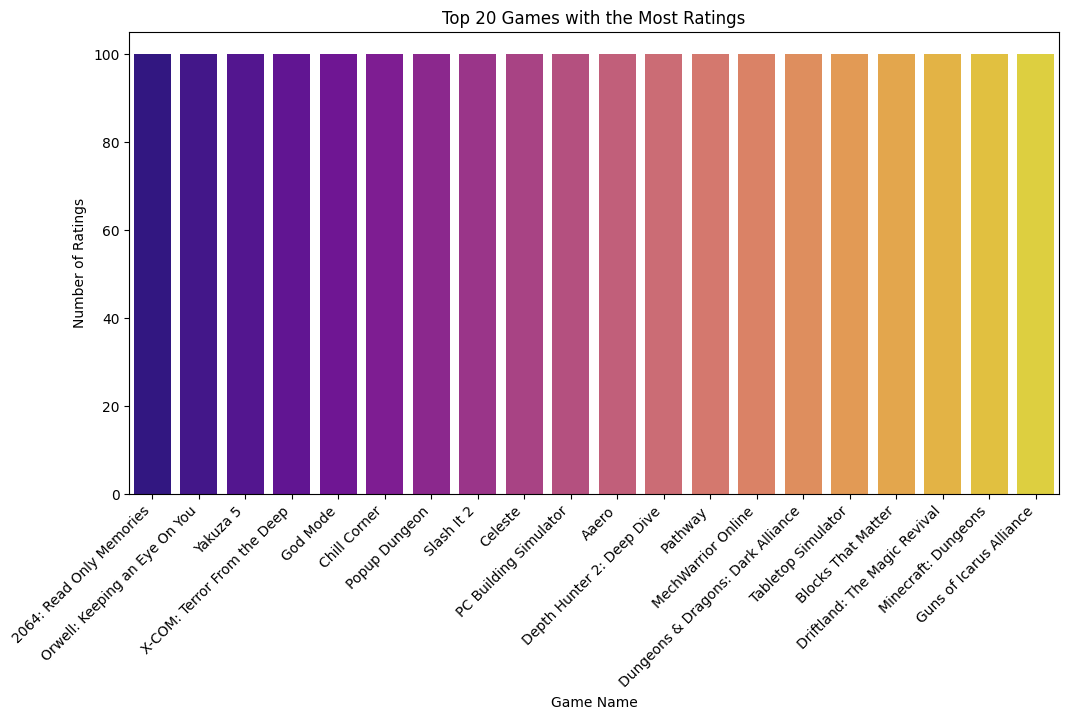

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by user_id and count the number of ratings
num_ratings = merged_df.groupby('name')['rating'].count().sort_values(ascending=False)

# Plot the top N user with the most ratings
N = 20  # Change to display a different number of top users
plt.figure(figsize=(12, 6))
sns.barplot(x=num_ratings[:N].index, y=num_ratings[:N], palette='plasma')
plt.title(f'Top {N} Games with the Most Ratings')
plt.xlabel('Game Name')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


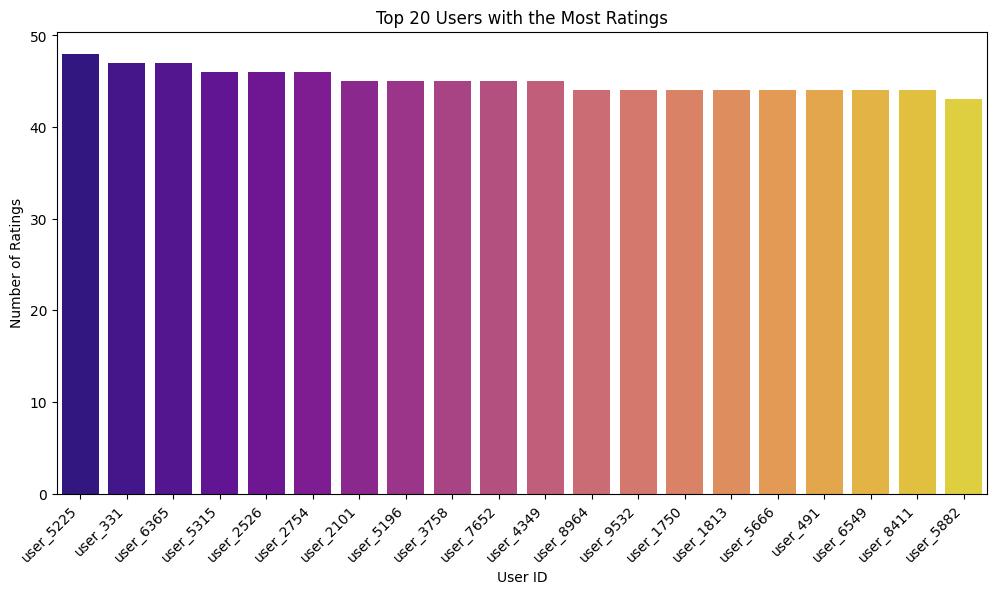

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by user_id and count the number of ratings
num_ratings = merged_df.groupby('user_id')['rating'].count().sort_values(ascending=False)

# Plot the top N users with the most ratings
N = 20  # Change to display a different number of top users
plt.figure(figsize=(12, 6))
sns.barplot(x=num_ratings[:N].index, y=num_ratings[:N], palette='plasma')
plt.title(f'Top {N} Users with the Most Ratings')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

Now, let's create an effective recommendation system by focusing on **dedicated gamers** (i.e., users who have rated at least 20 games) while filtering out **part-time gamers** to ensure reliable feedback. Additionally, we will include only **those games that have received at least 20% of the maximum number of ratings**. This approach guarantees that our recommendations are based on consistent and well-rated data, enhancing both accuracy and relevance.

In [63]:
# Find users who have rated at least 20 games
dedicated_users = merged_df['user_id'].value_counts()[merged_df['user_id'].value_counts() >20].index

# Filter the merged_df to include only these users
df = merged_df[merged_df['user_id'].isin(dedicated_users)]

df.head()


,game_id,user_id,rating,name
0,3498,user_4971,4,Grand Theft Auto V
1,3498,user_957,3,Grand Theft Auto V
2,3498,user_2078,2,Grand Theft Auto V
3,3498,user_7147,2,Grand Theft Auto V
4,3498,user_8630,5,Grand Theft Auto V


In [64]:
# let's extract the games that has more than 0 ratings
number_rating = df.groupby('name')['rating'].count().reset_index()
number_rating.head()

,name,rating
0,.hack//G.U. Last Recode,61
1,//N.P.P.D. RUSH//- The milk of Ultraviolet,74
2,10 Second Ninja X,37
3,100% Orange Juice,41
4,11-11 Memories Retold,19


we have grouped the game names based on the nuber of ratings recived.

In [65]:
number_rating.rename(columns= {'rating':'number_of_ratings'}, inplace=True)
number_rating.head()

,name,number_of_ratings
0,.hack//G.U. Last Recode,61
1,//N.P.P.D. RUSH//- The milk of Ultraviolet,74
2,10 Second Ninja X,37
3,100% Orange Juice,41
4,11-11 Memories Retold,19


In [66]:
# Now merge this dataframe with df
useful_ratings = df.merge(number_rating,on='name')
useful_ratings.head()

,game_id,user_id,rating,name,number_of_ratings
0,3498,user_4971,4,Grand Theft Auto V,93
1,3498,user_957,3,Grand Theft Auto V,93
2,3498,user_2078,2,Grand Theft Auto V,93
3,3498,user_7147,2,Grand Theft Auto V,93
4,3498,user_8630,5,Grand Theft Auto V,93


In [67]:
useful_ratings.shape

(257879, 5)

In [68]:
useful_ratings[useful_ratings['number_of_ratings']<10]

,game_id,user_id,rating,name,number_of_ratings
12892,3842,user_4942,2,Battlefield 4,9
12893,3842,user_77,4,Battlefield 4,9
12894,3842,user_4099,2,Battlefield 4,9
12895,3842,user_723,3,Battlefield 4,9
12896,3842,user_8057,2,Battlefield 4,9
...,...,...,...,...,...
242816,510043,user_2419,5,Impostor Factory,9
242817,510043,user_1476,2,Impostor Factory,9
242818,510043,user_8622,3,Impostor Factory,9
242819,510043,user_7213,4,Impostor Factory,9


In [69]:
df1=useful_ratings[useful_ratings['number_of_ratings']>40]
df1.head()

,game_id,user_id,rating,name,number_of_ratings
0,3498,user_4971,4,Grand Theft Auto V,93
1,3498,user_957,3,Grand Theft Auto V,93
2,3498,user_2078,2,Grand Theft Auto V,93
3,3498,user_7147,2,Grand Theft Auto V,93
4,3498,user_8630,5,Grand Theft Auto V,93


In [70]:
df1.shape

(213076, 5)

In [71]:
df1["name"].nunique()

3177

### Data Filtering Process:

1. Filtered the dataset to include only dedicated gamers who have rated greater than  20 games.
    - This step helps reduce noise from casual users and part-time gamers.
2. Selected games that received more than 40 ratings to ensure popularity and reliability.
   - This guarantees that the recommendations are based on well-rated and widely played games.
3. As a result, the number of games was reduced from 5,000 to 3,177.
   - This reduction is crucial to maintain data quality, as it eliminates less popular or rarely rated games,leading to more accurate and meaningful recommendations.


### User-Item Interaction Table

In [72]:
pivot_table=pd.pivot(df1,index="name",columns="user_id",values="rating")
pivot_table

user_id,user_1,user_10,user_100,user_1000,user_1001,user_1002,user_1003,user_1004,user_1005,user_1006,...,user_9990,user_9991,user_9992,user_9993,user_9994,user_9995,user_9996,user_9997,user_9998,user_9999
name,,,,,,,,,,,,,,,,,,,,,
.hack//G.U. Last Recode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
//N.P.P.D. RUSH//- The milk of Ultraviolet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100% Orange Juice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112 Operator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Labours of Hercules,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
missed messages.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shapez.io,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
theHunter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Null values occur because not all users have rated every game, and we can handle them by replacing with zeros

In [73]:
pivot_table.fillna(0,inplace=True)
pivot_table.sample(20)

user_id,user_1,user_10,user_100,user_1000,user_1001,user_1002,user_1003,user_1004,user_1005,user_1006,...,user_9990,user_9991,user_9992,user_9993,user_9994,user_9995,user_9996,user_9997,user_9998,user_9999
name,,,,,,,,,,,,,,,,,,,,,
Rogue Company,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weird Worlds: Return to Infinite Space,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Borderlands 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Need for Speed Payback,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Don't Starve Together,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RimWorld,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shop Titans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BATTLETECH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Railroad Corporation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


We use **Compressed Sparse Row (CSR)** matrix because it efficiently stores sparse data (data with many zeros) by compressing only non-zero values, reducing memory usage and speeding up calculations, especially in collaborative filtering and similarity computations.

In [74]:
from scipy.sparse import csr_matrix
sparse_matrix=csr_matrix(pivot_table)

Cosine_Similarity

In [75]:
#calculate cosine similarity
cosine_cf_sim=cosine_similarity(sparse_matrix)
cosine_cf_sim.shape

(3177, 3177)

In [76]:
sorted(cosine_cf_sim[0],reverse=True)

[np.float64(1.0000000000000007),
 np.float64(0.08075552977281146),
 np.float64(0.07736259317697529),
 np.float64(0.07374708434323732),
 np.float64(0.06774765538517591),
 np.float64(0.06311925662038953),
 np.float64(0.06261624509338029),
 np.float64(0.057694537206694284),
 np.float64(0.05461665927244609),
 np.float64(0.05330131478242467),
 np.float64(0.05224855636149059),
 np.float64(0.05061620698867178),
 np.float64(0.04942999738633558),
 np.float64(0.04907769068657877),
 np.float64(0.049071749688040546),
 np.float64(0.04871786692225828),
 np.float64(0.048135793691333625),
 np.float64(0.048008035297237295),
 np.float64(0.04743260738764472),
 np.float64(0.046748000380053736),
 np.float64(0.04598759429393377),
 np.float64(0.045888546082096734),
 np.float64(0.045736441648772094),
 np.float64(0.044766288132940264),
 np.float64(0.04465847837758892),
 np.float64(0.04438130973884339),
 np.float64(0.04415142283078382),
 np.float64(0.04400815120531387),
 np.float64(0.04393809877993081),
 np.flo

### Function to recommend game based on a given target game.

In [77]:
def cf_recommend_games(game):
    # Fetch the index of the target game
    index = np.where(pivot_table.index == game)[0][0]

    # Get similarity scores and sort them in descending order
    cf_sim_scores = sorted(list(enumerate(cosine_cf_sim[index])), key=lambda x: x[1],reverse=True)

    # Exclude the target game itself and get the top 10 recommendations
    cf_sim_scores = cf_sim_scores[1:11]

   # Prepare the recommended games DataFrame
    recommended_games = pd.DataFrame(
        [{"game_id": new_df.iloc[i[0]].game_id, "name": pivot_table.index[i[0]], "cf_score": i[1]} for i in cf_sim_scores]
    )
    return recommended_games

In [78]:
cf_recommend_games("Grand Theft Auto V")

,game_id,name,cf_score
0,4012,Concrete Genie,0.073463
1,21371,The Cat Lady,0.060914
2,313826,Majesty 2 Collection,0.059984
3,19412,Parkan 2,0.059777
4,3598,My Singing Monsters,0.057632
5,2188,Tiny Echo,0.057001
6,47466,Tom Clancy's Splinter Cell: Pandora Tomorrow,0.056353
7,14501,Ninja Gaiden II,0.055926
8,11737,Lord of the Rings: War in the North,0.054494
9,20980,Dark Souls: Remastered,0.054481


In [79]:
cf_recommend_games("The Crew")

,game_id,name,cf_score
0,17470,The Stillness of the Wind,0.069626
1,4744,DC Universe Online,0.068815
2,42912,Shadow Complex Remastered,0.063290
3,2845,DRAGON QUEST BUILDERS,0.062866
4,1140,Coffee Talk,0.060490
5,4302,Saturday Morning RPG,0.060465
6,17572,Anachronox,0.060037
7,17337,Minit,0.057920
8,440086,Lovecraft's Untold Stories,0.056850
9,60179,Cube Destroyer,0.056686


### Comparison of Content-Based and Collaborative Filtering Recommendations

After building both content-based and collaborative filtering models, we observed significant differences in the recommended games for *Grand Theft Auto V (GTA V)*.

1. **Content-Based Filtering:**  
   - Recommended games mostly include other titles from the *Grand Theft Auto* series and similar open-world, action-adventure games.  
   - The focus here is on content similarity, such as game descriptions, genres, or metadata.  
   - Examples: *Grand Theft Auto: San Andreas*, *Grand Theft Auto IV*, *Dead Island 2*, *Dead Rising 3 Apocalypse Edition*.  

2. **Collaborative Filtering:**  
   - Recommendations include a diverse set of games that were commonly played by users who also played *GTA V*.  
   - This method captures player behavior and ratings rather than content similarity.  
   - Examples: *Concrete Genie*,*Dark Souls: Remastered*, *Tom Clancy's Splinter Cell: Pandora Tomorrow*, *Ninja Gaiden II*.

In [80]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def hybrid_recommend_games(game_name, cbf_weight=0.7, cf_weight=0.3):
    """
    Generates hybrid game recommendations using a weighted combination of
    content-based filtering (CBF) and collaborative filtering (CF).

    Args:
        game_name: Name of the game to get recommendations for
        cbf_weight: Weight for CBF scores (default 0.7)
        cf_weight: Weight for CF scores (default 0.3)

    Returns:
        DataFrame with top 10 hybrid recommendations
    """
    try:
        # Get content-based recommendations
        cbf_rec = cbf_recommend_games(game_name)

        # Get collaborative filtering recommendations
        try:
            cf_rec = cf_recommend_games(game_name)
            cf_available = True
        except (IndexError, KeyError):
            print(f"No CF recommendations found for '{game_name}'. Using CBF only.")
            cf_rec = cbf_rec[['game_id', 'name']].copy()  # Retain all CBF games
            cf_rec['cf_score'] = 0  # Set CF score to 0
            cf_available = False

        # Merge recommendations
        hybrid_df = pd.merge(
            cbf_rec,
            cf_rec,
            on=['game_id', 'name'],
            how='outer'  # Keep all CBF results even if no CF match
        ).fillna(0)

        # Normalize scores using MinMaxScaler only if more than one unique value
        scaler = MinMaxScaler()

        if hybrid_df['cbf_score'].nunique() > 1:
            hybrid_df['cbf_score'] = scaler.fit_transform(hybrid_df[['cbf_score']])

        if cf_available and hybrid_df['cf_score'].nunique() > 1:
            hybrid_df['cf_score'] = scaler.fit_transform(hybrid_df[['cf_score']])

        # Compute hybrid score
        hybrid_df['hybrid_score'] = (cbf_weight * hybrid_df['cbf_score']) + (cf_weight * hybrid_df['cf_score'])

        # If CF is unavailable, return only CBF results
        if not cf_available:
            return cbf_rec[['game_id', 'name', 'cbf_score']].rename(columns={'cbf_score': 'hybrid_score'}).head(10)

        # Sort and return top 10
        return hybrid_df.sort_values('hybrid_score', ascending=False)[['game_id', 'name', 'hybrid_score']].head(10)

    except Exception as e:
        print(f"Error in hybrid recommendations: {str(e)}")
        return pd.DataFrame()


### Hybrid Game Recommendation Function  

This function combines **Content-Based Filtering (CBF)** and **Collaborative Filtering (CF)**  
to provide better game recommendations using a **weighted hybrid approach**.

---

**Parameters:**  
- `game_name` (str): Name of the input game.  
- `cbf_weight` (float): Weight assigned to CBF scores (**default = 0.7**).  
- `cf_weight` (float): Weight assigned to CF scores (**default = 0.3**).  

---

**Process:**  
1. **Fetch CBF recommendations** (based on game features like genre, description).  
2. **Fetch CF recommendations** (based on user interactions).  
3. **Merge both lists** and assign a weighted score.  
4. **Normalize scores** using `MinMaxScaler` – CBF and CF scores have different scales, making direct comparison unfair. MinMaxScaler transforms them to a common range **[0,1]** for balanced weighting.  
5. **Compute a hybrid score** using the formula:  
   `hybrid_score = (cbf_weight * cbf_score) + (cf_weight * cf_score)`  
6. **Handle missing CF data** (if CF is unavailable, use only CBF).  
7. **Return the top 10 recommendations** sorted by the hybrid score.  


In [81]:
hybrid_recommend_games("Grand Theft Auto V")

,game_id,name,hybrid_score
19,387345,Yakuza 4 Remastered,0.700000
1,432,Grand Theft Auto III,0.575509
6,4414,Grand Theft Auto: Episodes from Liberty City,0.498455
0,416,Grand Theft Auto: San Andreas,0.489576
16,42857,Dead Island 2,0.343500
2,1999,Retro City Rampage DX,0.338148
5,4012,Concrete Genie,0.300000
11,17666,Dead Rising 3 Apocalypse Edition,0.297981
9,13252,La-Mulana,0.275455
7,4459,Grand Theft Auto IV,0.258795


**Our hybrid_recommend_games function works well, combining CBF (Yakuza 4, GTA III, GTA: Episodes, GTA: San Andreas, Dead Island 2) and CF (Concrete Genie) with 70% CBF and 30% CF weighting.**

In [82]:
hybrid_recommend_games("The Crew")

,game_id,name,hybrid_score
7,4923,Prototype,0.700000
19,573123,Life is Strange: True Colors,0.499593
16,62864,Simple Story - Alex,0.384097
12,19372,Silent Hill Homecoming,0.343133
0,37,Star Trek: Bridge Crew,0.308379
14,43004,Space Crew,0.308086
1,295,Oxenfree,0.306356
17,356714,Among Us,0.304043
10,17470,The Stillness of the Wind,0.300000
6,4744,DC Universe Online,0.296505


In [83]:
hybrid_recommend_games("Impostor Factory") #The game is not available in collaborative filtering

No CF recommendations found for 'Impostor Factory'. Using CBF only.


,game_id,name,hybrid_score
0,548036,Loop Hero,0.235477
1,2184,Moon Hunters,0.231860
2,327260,Twelve Minutes,0.222817
3,452638,Stray,0.212575
4,8062,Hexcells,0.196187
5,58764,Outer Wilds,0.177031
6,10090,Beholder,0.176786
7,304320,Cat Quest II,0.176121
8,933,The Sexy Brutale,0.171538
9,19562,Hot Tin Roof: The Cat That Wore A Fedora,0.163838


In [84]:
'''import pickle

pickle.dump(new_df.to_dict(),open("games_dict.pkl","wb"))

pickle.dump(cosine_sim,open("cosine_sim.pkl","wb"))
pickle.dump(pivot_table,open("pivot_table.pkl","wb"))
pickle.dump(cosine_cf_sim,open("cosine_cf_sim.pkl","wb"))'''

'import pickle\n\npickle.dump(new_df.to_dict(),open("games_dict.pkl","wb"))\n\npickle.dump(cosine_sim,open("cosine_sim.pkl","wb"))\npickle.dump(pivot_table,open("pivot_table.pkl","wb"))\npickle.dump(cosine_cf_sim,open("cosine_cf_sim.pkl","wb"))'